# Survival prediction

<div style="background-color: #f5f1f6; padding: 10px;">

### Prediction target

--> time to death from CXR scan

#### ***Model variants***

##### 1. **Predict time to death from clinical variables (up to CXR exam)**

##### 2. **Predict time to death from image information of last CXR exam**

##### 3. **Predict time to death by from image information of randomly selected CXR exam**

##### 4. **Predict time to death with a time dependent survival model using all CXR exams**

In [48]:
# Import libraries
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [49]:
# load data and embeddings
data = pd.read_csv('data_processed/cohort_embeddings_lastscan.csv')
embeddings = np.load('data_processed/embeddings_lastscan.npy')

In [50]:
data

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,...,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,embedding,time_to_death,death_category
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23,2180-07-23,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,2906,2258,2180-07-23,80556.875,CHEST (PORTABLE AP),antero-posterior,Erect,[-0.50707304 -1.5622804 0.37747228 ... -1.46...,48,48 days
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27,2189-06-27,0.497535,2189-06-27 07:38:00,2189-07-03 03:00:00,...,3056,2544,2189-06-27,64348.484,CHEST (PORTABLE AP),antero-posterior,Erect,[ 0.2519467 -1.2917526 1.0152953 ... -2.10...,1521,1521 days
2,10002428,28662225,33987268,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-12,2156-04-17,4.981134,2156-04-12 14:16:00,2156-04-29 16:26:00,...,3056,2544,2156-04-16,30029.015,CHEST (PORTABLE AP),antero-posterior,Erect,[-1.0334531 -0.75865674 0.6928189 ... -2.23...,-1,Censored (No Death)
3,10003019,22774359,30676350,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2175-10-08,2175-10-09,0.709213,2175-10-08 13:56:00,2175-10-17 17:30:00,...,3056,2544,2175-10-08,105006.968,postero-anterior,Erect,NaN,[ 0.17203122 -0.8430859 1.4200679 ... -1.33...,-1,Censored (No Death)
4,10003502,29011269,35796366,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2169-08-26,2169-08-27,1.039456,2169-08-26 16:14:00,2169-08-28 15:20:00,...,2712,2230,2169-08-27,81656.250,CHEST (PORTABLE AP),antero-posterior,Erect,[-0.7301748 -0.95917726 0.807611 ... -1.23...,14,14 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9753,19998330,23151993,31085771,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2178-09-20,2178-09-21,0.851690,2178-09-20 20:20:00,2178-09-23 18:30:00,...,2768,2544,2178-09-20,180917.656,CHEST (PORTABLE AP),antero-posterior,Erect,[-0.3335524 -0.4049817 0.64792466 ... -1.57...,79,79 days
9754,19998843,24842066,30988867,Trauma SICU (TSICU),Trauma SICU (TSICU),2187-02-05,2187-02-08,3.338646,2187-02-05 09:27:00,2187-02-08 17:28:00,...,2539,2827,2187-02-08,60546.687,CHEST (PORTABLE AP),antero-posterior,Erect,[-0.69910395 -1.545928 0.87855947 ... -1.65...,0,0 days
9755,19999287,22997012,37692584,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2197-07-26,2197-07-27,1.525266,2197-07-26 03:29:00,2197-07-31 14:00:00,...,3056,2544,2197-07-26,25712.640,CHEST (PORTABLE AP),antero-posterior,Erect,[-0.5933177 -1.1098459 0.8882481 ... -1.60...,38,38 days
9756,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19,2148-11-26,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,...,2544,3056,2148-11-19,224703.375,CHEST (PORTABLE AP),antero-posterior,Erect,[-0.0462219 -1.9575974 0.65582377 ... -1.92...,-1,Censored (No Death)


<div style="background-color: #f5f1f6; padding: 10px;">

**Survival prediction needs:** 

*event* (does death occur in observed time?) and *time to event* (time from cxr-image to death / discharge time)

In [51]:
# make event column
data['event'] = data['time_to_death'].apply(lambda x: 0 if x == -1 else 1)

# calculate time to death in days 
# already done for death cases
# --> for censored cases, use last follow-up date

data['time_to_event'] = data['time_to_death'].copy()
# if -1, calculate 'StudyDate' to 'dischtime' difference
data['time_to_event'] = data.apply(lambda row: (pd.to_datetime(row['dischtime']) - pd.to_datetime(row['StudyDate'])).days if row['time_to_death'] == -1 else row['time_to_death'], axis=1)

In [55]:
data[['subject_id', 'time_to_death', 'time_to_event', 'event', 'admittime', 'dischtime', 'StudyDate', 'dod']].head(15)

,subject_id,time_to_death,time_to_event,event,admittime,dischtime,StudyDate,dod
0,10000032,48,48,1,2180-07-23 12:35:00,2180-07-25 17:55:00,2180-07-23,2180-09-09
1,10000980,1521,1521,1,2189-06-27 07:38:00,2189-07-03 03:00:00,2189-06-27,2193-08-26
2,10002428,-1,13,0,2156-04-12 14:16:00,2156-04-29 16:26:00,2156-04-16,NaN
3,10003019,-1,9,0,2175-10-08 13:56:00,2175-10-17 17:30:00,2175-10-08,NaN
4,10003502,14,14,1,2169-08-26 16:14:00,2169-08-28 15:20:00,2169-08-27,2169-09-10
5,10004235,-1,4,0,2196-02-24 14:38:00,2196-03-04 14:02:00,2196-02-29,NaN
6,10007058,-1,4,0,2167-11-07 19:05:00,2167-11-11 14:23:00,2167-11-07,NaN
7,10007795,-1,9,0,2136-04-10 20:33:00,2136-05-02 16:35:00,2136-04-23,NaN
8,10007920,-1,6,0,2138-12-04 16:52:00,2138-12-10 17:56:00,2138-12-04,NaN
9,10007928,-1,3,0,2129-04-05 22:56:00,2129-04-11 17:25:00,2129-04-08,NaN


In [56]:
# check for nans in time_to_event and event
data[['time_to_event', 'event']].isna().sum()

time_to_event    0
event            0
dtype: int64

<div style="background-color: #f5f1f6; padding: 10px;">

**Prepare dataset for survival modeling**

Make 'event' column that indicates if event occured or not.
Make 'time_to_event' column that calculates either:
- time to death from study date (last cxr exam)
- time to last discharge time from study date (last cxr exam)

In [61]:
cph = CoxPHFitter()
data_train = data[['time_to_event', 'event',
                   'insurance', 'age_at_admission', 'admission_type']].copy()

# make categorical columns into category dtype
categorical_cols = ['insurance', 'admission_type']
# make dummies for categorical columns
data_train = pd.get_dummies(data_train, columns=categorical_cols, drop_first=True)
cph.fit(data_train, duration_col='time_to_event', event_col='event')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<lifelines.CoxPHFitter: fitted with 9758 total observations, 6896 right-censored observations>

In [65]:
data_train

,time_to_event,event,age_at_admission,insurance_Medicare,insurance_No charge,insurance_Other,insurance_Private,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT
0,48,1,52,False,False,False,False,False,False,False,False,True,False,False,False
1,1521,1,76,True,False,False,False,False,False,False,False,True,False,False,False
2,13,0,81,True,False,False,False,False,False,False,False,True,False,False,False
3,9,0,73,True,False,False,False,False,False,False,False,True,False,False,False
4,14,1,94,True,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9753,79,1,72,True,False,False,False,False,False,False,False,True,False,False,False
9754,0,1,45,False,False,False,False,False,False,False,False,True,False,False,False
9755,38,1,77,True,False,False,False,False,False,False,False,True,False,False,False
9756,15,0,43,False,False,False,False,False,False,True,False,False,False,False,False


In [62]:
cph.print_summary()

AttributeError: The '.style' accessor requires jinja2

<lifelines.CoxPHFitter: fitted with 9758 total observations, 6896 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 9758
number of events observed = 2862
   partial log-likelihood = -20004.03
         time fit was run = 2025-12-11 14:50:42 UTC

---
                                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                   
age_at_admission                            0.01      1.01      0.00            0.01            0.01                1.01                1.01
insurance_Medicare                          0.07      1.07      0.06           -0.06            0.19                0.94                1.21
insurance_No charge                        -8.87      0.00    404.60         -801.87          784.13                0.00                 inf
insurance_Other                            -0.02      0.98      0.18           -0.36            0.32                0.70                1.38
insurance_Private                           0.07      1.08      0.07           -0.07            0.21                0.94                1.24
admission_type_DIRECT EMER.                 0.31      1.36      1.01           -1.66            2.28                0.19                9.79
admission_type_DIRECT OBSERVATION          -8.30      0.00   1141.26        -2245.12         2228.52                0.00                 inf
admission_type_ELECTIVE                     0.11      1.12      1.01           -1.86            2.09                0.15                8.05
admission_type_EU OBSERVATION               1.70      5.48      1.07           -0.40            3.80                0.67               44.56
admission_type_EW EMER.                     0.66      1.94      1.00           -1.30            2.62                0.27               13.78
admission_type_OBSERVATION ADMIT            0.96      2.61      1.00           -1.00            2.92                0.37               18.63
admission_type_SURGICAL SAME DAY ADMISSION  0.37      1.44      1.00           -1.60            2.34                0.20               10.35
admission_type_URGENT                       0.77      2.15      1.00           -1.20            2.73                0.30               15.31

                                            cmp to     z      p  -log2(p)
covariate                                                                
age_at_admission                              0.00  6.51 <0.005     33.60
insurance_Medicare                            0.00  1.01   0.31      1.67
insurance_No charge                           0.00 -0.02   0.98      0.03
insurance_Other                               0.00 -0.11   0.91      0.13
insurance_Private                             0.00  1.05   0.30      1.76
admission_type_DIRECT EMER.                   0.00  0.31   0.76      0.40
admission_type_DIRECT OBSERVATION             0.00 -0.01   0.99      0.01
admission_type_ELECTIVE                       0.00  0.11   0.91      0.13
admission_type_EU OBSERVATION                 0.00  1.59   0.11      3.16
admission_type_EW EMER.                       0.00  0.66   0.51      0.98
admission_type_OBSERVATION ADMIT              0.00  0.96   0.34      1.57
admission_type_SURGICAL SAME DAY ADMISSION    0.00  0.37   0.71      0.49
admission_type_URGENT                         0.00  0.76   0.44      1.17
---
Concordance = 0.58
Partial AIC = 40034.06
log-likelihood ratio test = 144.09 on 13 df
-log2(p) of ll-ratio test = 78.05

<Figure size 1000x600 with 0 Axes>

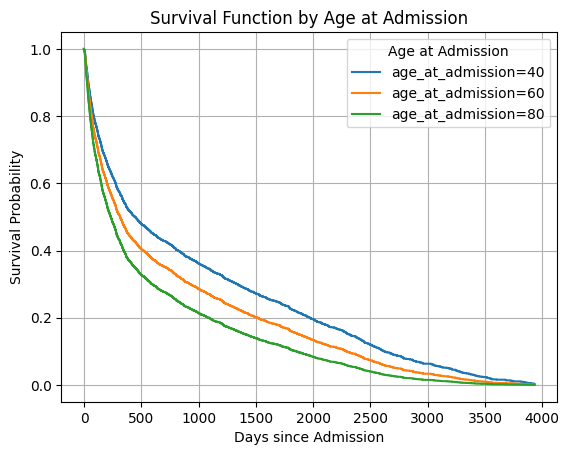

In [64]:
# plot the survival function with mean and median cutoffs
plt.figure(figsize=(10,6))
cph.plot_partial_effects_on_outcome(covariates='age_at_admission',
                                    values=[40, 60, 80],
                                    plot_baseline=False)
plt.title('Survival Function by Age at Admission')
plt.xlabel('Days since Admission')
plt.ylabel('Survival Probability')
plt.legend(title='Age at Admission')
plt.grid()
plt.show()


<Figure size 1000x600 with 0 Axes>

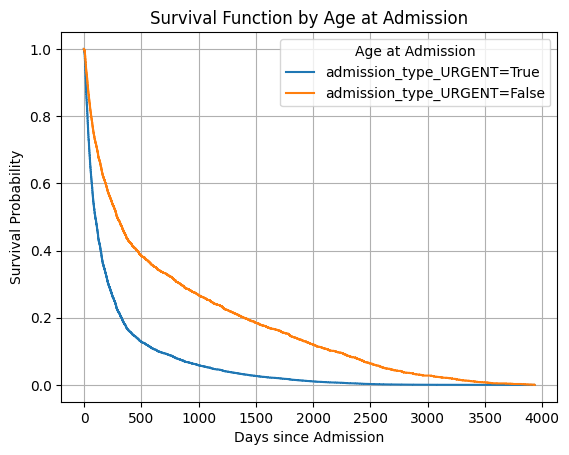

In [68]:
# plot the survival function with mean and median cutoffs
plt.figure(figsize=(10,6))
cph.plot_partial_effects_on_outcome(covariates='admission_type_URGENT',
                                    values=[True, False],
                                    plot_baseline=False)
plt.title('Survival Function by Age at Admission')
plt.xlabel('Days since Admission')
plt.ylabel('Survival Probability')
plt.legend(title='Age at Admission')
plt.grid()
plt.show()
